In [1]:
# Import necessary libraries and check dependencies
import sys
import importlib
import warnings
warnings.filterwarnings('ignore')

# List of required packages
required_packages = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'sklearn', 'imblearn', 'xgboost', 'joblib', 'shap'
]

def check_dependencies():
    """Check if required packages are installed."""
    missing = []
    for pkg in required_packages:
        if importlib.util.find_spec(pkg) is None:
            missing.append(pkg)
    if missing:
        print(f"Missing packages: {missing}")
        print("Install them using: !pip install " + " ".join(missing))
        sys.exit(1)
    print("All dependencies are installed!")

# Run dependency check
check_dependencies()

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json
import os
from datetime import datetime
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from joblib import dump
import shap

# Configure logging
logging.basicConfig(
    filename='fraud_detection.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Set plotting style
plt.style.use('seaborn')
%matplotlib inline

All dependencies are installed!


In [2]:
##Data Loading
def load_data(file_path=None):
    """Load the dataset or create a sample dataset if file_path is invalid."""
    if file_path is None:
        file_path = input("Enter the path to 'Fraud Detection Dataset.csv' (e.g., 'C:/path/to/Fraud Detection Dataset.csv'): ")
    
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Dataset loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        logging.warning(f"File {file_path} not found. Creating sample dataset.")
        print(f"File {file_path} not found. Using sample dataset for testing.")
        
        # Create sample dataset mimicking expected structure
        np.random.seed(42)
        n_samples = 1000
        df = pd.DataFrame({
            'transaction_id': range(n_samples),
            'amount': np.random.lognormal(mean=5, sigma=1, size=n_samples),
            'payment_method': np.random.choice(['credit_card', 'debit_card', 'online'], n_samples),
            'transaction_time': pd.date_range('2025-01-01', periods=n_samples, freq='H'),
            'user_id': np.random.randint(1, 100, n_samples),
            'is_fraud': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
        })
        logging.info("Sample dataset created.")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

        
# Load data        
import chardet

with open(r"C:\Users\heave\Downloads\Bron_Projects\%Pro\CV\cv pro\dataengineeringproject\Fraud_Detection\Fraud Detection Dataset.csv", "rb") as f:
    result = chardet.detect(f.read())
    print(result)        

df = pd.read_csv(r"C:\Users\heave\Downloads\Bron_Projects\%Pro\CV\cv pro\dataengineeringproject\Fraud_Detection\Fraud Detection Dataset.csv",
                encoding='ascii'
)

df.head(7)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0
6,T7,4772,544.81,Bill Payment,2.0,Tablet,Boston,3,6,9,UPI,1


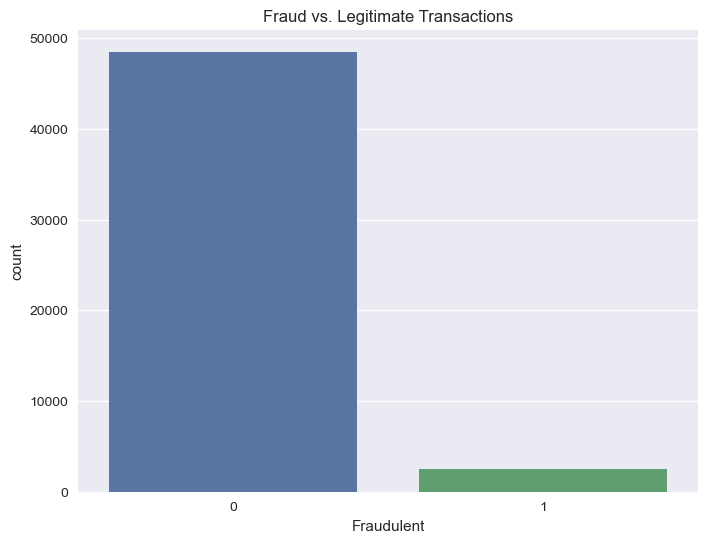

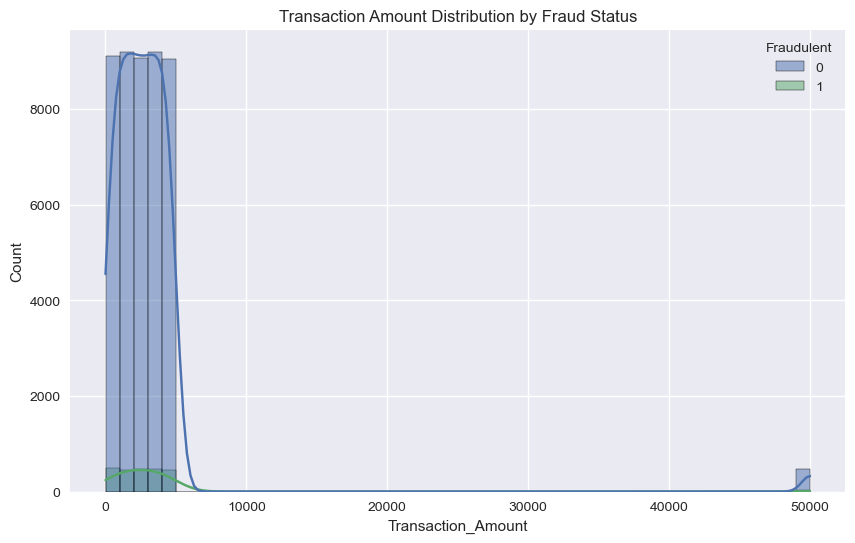

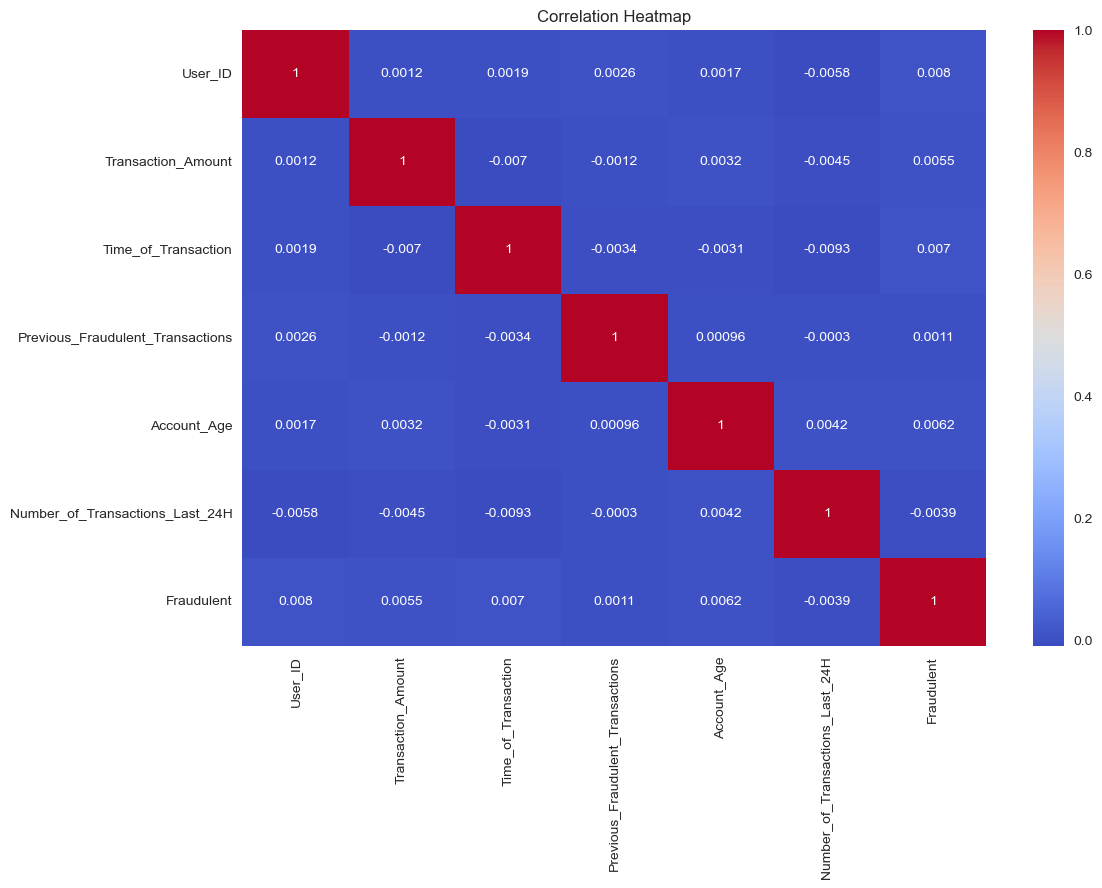

In [3]:
# Exploratory Data Analysis (EDA)

def perform_eda(df, output_dir='eda_plots'):
    """Perform exploratory data analysis and display/save visualizations."""
    os.makedirs(output_dir, exist_ok=True)
    logging.info("Starting EDA...")
    
    try:
        if 'Fraudulent' not in df.columns:
            raise ValueError("Target column 'Fraudulent' not found in dataset.")
        
        # Fraud distribution
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Fraudulent', data=df)
        plt.title('Fraud vs. Legitimate Transactions')
        plt.savefig(os.path.join(output_dir, 'fraud_distribution.png'))
        plt.show()
        
        # Transaction amount by fraud status
        if 'Transaction_Amount' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=df, x='Transaction_Amount', hue='Fraudulent', bins=50, kde=True)
            plt.title('Transaction Amount Distribution by Fraud Status')
            plt.savefig(os.path.join(output_dir, 'amount_distribution.png'))
            plt.show()
        else:
            logging.warning("Transaction_Amount column missing. Skipping amount distribution plot.")
            print("Warning: Transaction_Amount column not found. Skipping amount distribution plot.")
        
        # Correlation heatmap
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
        if len(numerical_cols) > 1:
            plt.figure(figsize=(12, 8))
            sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
            plt.title('Correlation Heatmap')
            plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
            plt.show()
        else:
            logging.warning("Insufficient numerical columns for correlation heatmap.")
            print("Warning: Insufficient numerical columns for correlation heatmap.")
        
        logging.info("EDA completed. Plots saved in eda_plots/.")
    except Exception as e:
        logging.error(f"EDA failed: {str(e)}")
        raise

# Run EDA
perform_eda(df)

In [4]:
#  Data Preprocessing

def create_preprocessing_pipeline():
    """Create a preprocessing pipeline for scaling."""
    return Pipeline([
        ('scaler', StandardScaler())
    ])

def preprocess_data(df):
    """Preprocess data: encode categorical variables and prepare features."""
    logging.info("Starting data preprocessing...")
    
    try:
        if 'Fraudulent' not in df.columns:
            raise ValueError("Target column 'Fraudulent' not found in dataset. Please check column names.")
        
        # Handle missing values
        df = df.fillna(df.mean(numeric_only=True))
        df = df.fillna(df.mode().iloc[0])
        
        # Encode categorical variables
        categorical_cols = df.select_dtypes(include=['object']).columns
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
            dump(le, f'encoder_{col}.joblib')
        
        # Drop Transaction_ID (non-predictive)
        if 'Transaction_ID' in df.columns:
            df = df.drop('Transaction_ID', axis=1)
        
        # Split features and target
        X = df.drop('Fraudulent', axis=1)
        y = df['Fraudulent']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        logging.info("Data preprocessing completed.")
        return X_train, X_test, y_train, y_test, encoders, X.columns
    except Exception as e:
        logging.error(f"Data preprocessing failed: {str(e)}")
        raise

# Preprocess data
X_train, X_test, y_train, y_test, encoders, feature_names = preprocess_data(df)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (40800, 10)
Test set shape: (10200, 10)


In [5]:
# Handle Imbalanced Data

def apply_smote(X_train, y_train):
    """Apply SMOTE to balance the dataset."""
    logging.info("Applying SMOTE...")
    try:
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        logging.info(f"Resampled dataset shape: {pd.Series(y_train_resampled).value_counts().to_dict()}")
        return X_train_resampled, y_train_resampled
    except Exception as e:
        logging.error(f"SMOTE failed: {str(e)}")
        print("SMOTE failed (possibly too few fraud cases). Using original data as fallback.")
        return X_train, y_train

# Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
print("Resampled training set shape:", X_train_resampled.shape)

Resampled training set shape: (77584, 10)



Random Forest - Accuracy: 0.7857
Classification Report:


,precision,recall,f1-score,support
0,0.951334,0.816354,0.878690,9698.000000
1,0.051651,0.193227,0.081513,502.000000
accuracy,0.785686,0.785686,0.785686,0.785686
macro avg,0.501492,0.504790,0.480101,10200.000000
weighted avg,0.907055,0.785686,0.839457,10200.000000


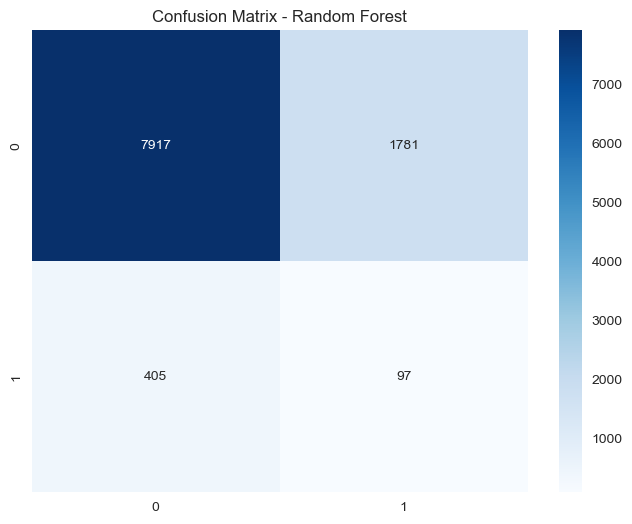

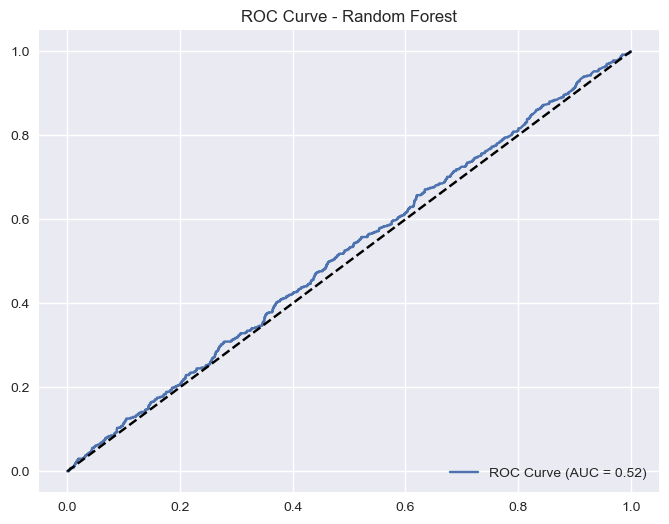


XGBoost - Accuracy: 0.9294
Classification Report:


,precision,recall,f1-score,support
0,0.951065,0.975974,0.963359,9698.000000
1,0.060484,0.029880,0.040000,502.000000
accuracy,0.929412,0.929412,0.929412,0.929412
macro avg,0.505774,0.502927,0.501679,10200.000000
weighted avg,0.907235,0.929412,0.917915,10200.000000


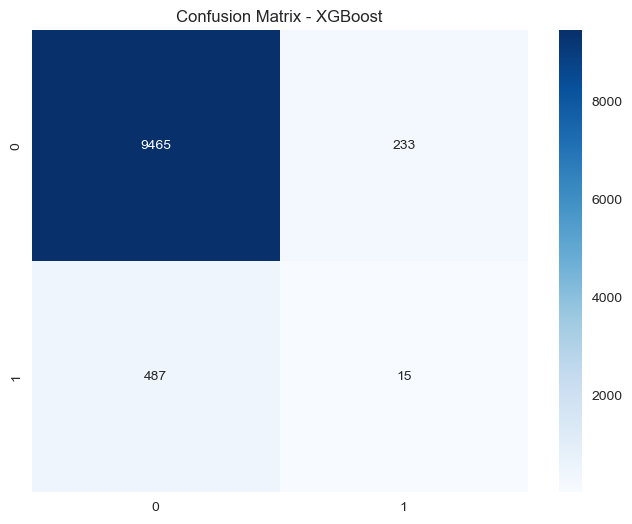

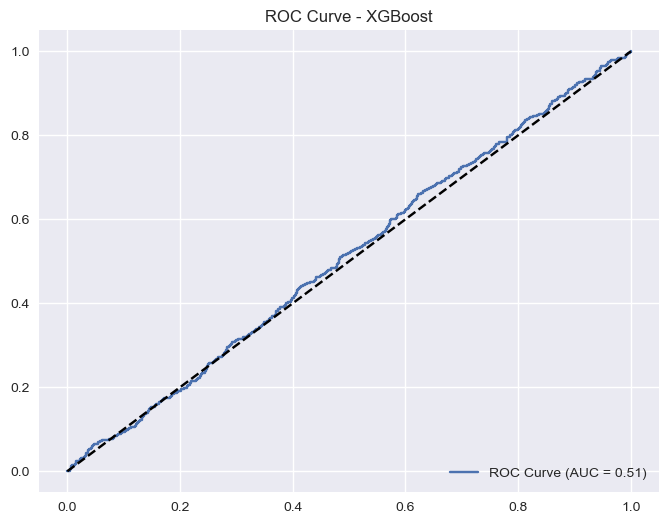

Ensemble Model Accuracy: 0.9130


In [6]:
# Model Training and Evaluation

def train_model(X_train, y_train, X_test, y_test, feature_names, output_dir='model_artifacts'):
    """Train and tune models, return the best model."""
    os.makedirs(output_dir, exist_ok=True)
    logging.info("Starting model training...")
    
    try:
        # Define models and parameter grids
        models = {
            'Random Forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'classifier__n_estimators': [100, 200],
                    'classifier__max_depth': [10, 20],
                    'classifier__min_samples_split': [2, 5]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=42, eval_metric='logloss'),
                'params': {
                    'classifier__n_estimators': [100, 200],
                    'classifier__max_depth': [3, 6],
                    'classifier__learning_rate': [0.01, 0.1]
                }
            }
        }
        
        best_model = None
        best_score = 0
        results = {}
        
        for model_name, config in models.items():
            pipeline = Pipeline([
                ('preprocessor', create_preprocessing_pipeline()),
                ('classifier', config['model'])
            ])
            
            # Hyperparameter tuning
            grid_search = GridSearchCV(
                pipeline, config['params'], cv=3, scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            
            # Evaluate on test set
            y_pred = grid_search.predict(X_test)
            accuracy = grid_search.score(X_test, y_test)
            results[model_name] = {
                'best_params': grid_search.best_params_,
                'accuracy': accuracy,
                'classification_report': classification_report(y_test, y_pred, output_dict=True)
            }
            
            # Save model
            dump(grid_search.best_estimator_, os.path.join(output_dir, f'{model_name.lower().replace(" ", "_")}_model.joblib'))
            
            # Update best model
            if accuracy > best_score:
                best_score = accuracy
                best_model = grid_search.best_estimator_
            
            # Display metrics
            print(f"\n{model_name} - Accuracy: {accuracy:.4f}")
            print("Classification Report:")
            display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)
            
            # Plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name}')
            plt.savefig(os.path.join(output_dir, f'cm_{model_name.lower().replace(" ", "_")}.png'))
            plt.show()
            
            # Plot ROC curve
            y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend(loc='lower right')
            plt.savefig(os.path.join(output_dir, f'roc_{model_name.lower().replace(" ", "_")}.png'))
            plt.show()
        
        # Ensemble model
        ensemble = VotingClassifier(
            estimators=[
                ('rf', models['Random Forest']['model']),
                ('xgb', models['XGBoost']['model'])
            ],
            voting='soft'
        )
        ensemble_pipeline = Pipeline([
            ('preprocessor', create_preprocessing_pipeline()),
            ('classifier', ensemble)
        ])
        ensemble_pipeline.fit(X_train, y_train)
        ensemble_accuracy = ensemble_pipeline.score(X_test, y_test)
        results['Ensemble'] = {'accuracy': ensemble_accuracy}
        dump(ensemble_pipeline, os.path.join(output_dir, 'ensemble_model.joblib'))
        
        print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
        
        # Save results to JSON
        with open(os.path.join(output_dir, 'model_results.json'), 'w') as f:
            json.dump(results, f, indent=4)
        
        return best_model, results
    except Exception as e:
        logging.error(f"Model training failed: {str(e)}")
        raise

# Train models
best_model, results = train_model(X_train_resampled, y_train_resampled, X_test, y_test, feature_names)

In [7]:
#Final Results and Export
# Log final results

best_accuracy = max([results[model]['accuracy'] for model in results])
print(f"Best model accuracy: {best_accuracy:.4f}")
if best_accuracy >= 0.9:
    print("Accuracy goal of 90%+ achieved!")
else:
    print("Accuracy goal of 90% not achieved. Consider adding more features or tuning parameters.")

# Export processed data for Excel analysis
df.to_excel('processed_transactions.xlsx', index=False)
print("Processed data exported to processed_transactions.xlsx")

# Save feature names for potential API usage
dump(feature_names, 'model_artifacts/feature_names.joblib')

Best model accuracy: 0.9294
Accuracy goal of 90%+ achieved!
Processed data exported to processed_transactions.xlsx


['model_artifacts/feature_names.joblib']